# Sarcasm detection - MAIN CAS, modules text analytics and big data, Rita Fleer

Data downloaded from:<br />
https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection

Main sources for models:<br />
https://www.kaggle.com/code/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy<br />
https://www.kaggle.com/code/eisgandar/sarcastic-headlines-detector-lstm<br />
https://www.kaggle.com/code/sahasourav17/sarcasm-detection-with-rnn-ensemble-svm-lr-nb<br />
https://www.kaggle.com/code/ashfakyeafi/sarcasm-detection<br />
https://colab.research.google.com/drive/1-QVZbgfd8vB0cRyZRU7pjnXk6d8Jq_zA#scrollTo=XMP7r5cUV6-B<br />
https://colab.research.google.com/drive/19BCYMuIxoOZ8cdmYtLOWLUZNQ2bs9_fm<br />
https://colab.research.google.com/drive/1yI2EiIqzZmXNzhQDgJqlKadoG1jjAXDm<br />
https://medium.com/optuna/using-optuna-to-optimize-tensorflow-hyperparameters-57b6d4d316a2<br />
https://www.analyticsvidhya.com/blog/2022/01/multi-label-text-classification-using-transfer-learning-powered-by-optuna/<br />


Installations: <br />
!pip install contractions <br />
!pip install lightgbm<br />
!pip install wordcloud<br />
!pip install scikit-learn<br />
!pip install nltk<br />
!pip install textblob<br />
!pip install tensorflow_hub<br />
!pip install transformers<br />
!pip install optuna<br />
!pip install plotly<br />

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

import contractions
from bs4 import BeautifulSoup
import re
import tqdm
import unicodedata

from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn import ensemble
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from termcolor import colored

#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import nltk

from nltk.corpus import stopwords
from textblob import Word
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

import re

import tensorflow as tf
import tensorflow_hub as hub
import transformers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau


from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

import string
from multiprocessing import Pool
import time

import optuna
from optuna.trial import TrialState
from sklearn.metrics import accuracy_score
import plotly

from nltk.stem import WordNetLemmatizer
from fuzzywuzzy import fuzz

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1) Load and Clean data


In [53]:
df = pd.read_json("data/Sarcasm_Headlines_Dataset_v2.json", lines=True)
del df['article_link'] # Deleting this column as it is of no use


df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [54]:
#find dublicates and drop them
print(df.duplicated().sum())
df.drop_duplicates(inplace = True)

116


In [55]:
#check if data set is approximately balanced (https://www.kaggle.com/code/eisgandar/sarcastic-headlines-detector-lstm)
df.groupby("is_sarcastic").count().style.background_gradient(cmap = "autumn")

,headline
is_sarcastic,
0,14951
1,13552


In [56]:
#Function to filter headlines that contain a specific term (just for fun)
def filter_headlines(term='florida man', data=df, column_name='headline'):
    filtered_headlines = data[data[column_name].str.contains(term, case=False)]

    return filtered_headlines

fh=filter_headlines()

for index, row in fh.iterrows():
    print(row['is_sarcastic'], row['headline'])

0 vladimir putin, florida man, arrested for trespassing at supermarket
0 florida man who landed gyrocopter at u.s. capitol rejects plea deals
0 florida man killed after standing up for gay friends, witnesses say
0 florida man gets arrested with 'go directly to jail' shirt
0 florida man head-butts a bus, knocks himself out
0 florida man sentenced for running over ducks with lawnmower


## Simple Preprocessing

based on https://colab.research.google.com/drive/1yI2EiIqzZmXNzhQDgJqlKadoG1jjAXDm#scrollTo=gCa_kwSoajaw

In [57]:
headlines = df["headline"]
labels = df["is_sarcastic"]

In [58]:
#headline preprocessing fuctions

def strip_html_tags(text): #probably irrelevant
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text): #probably irrelevant
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_headline(doc):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    doc = re.sub('[^\w\s]','',doc) #remove puctuation (added to original code)
    doc = re.sub('\d','',doc) #remove numbers (added to original code)
    # lower case and remove special characters\whitespaces 
    doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, flags=re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    return doc

### Sequential processing

In [9]:
# Sequential processing
start_time = time.time()
processed_headlines_sequential = list(headlines.map(pre_process_headline))
print(f"Time for preprocessing with single thread: {time.time() - start_time:.2f}s")

Time for preprocessing with single thread: 1.39s


In [10]:
processed_headlines_sequential[0:5]

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep totally nails why congress is falling short on gender racial equality',
 'eat your veggies deliciously different recipes',
 'inclement weather prevents liar from getting to work',
 'mother comes pretty close to using word streaming correctly']

### Parallel processing

In [59]:
#initial trial
start_time = time.time()

with Pool(6) as pool:
    processed_headlines_parallel = pool.map(pre_process_headline, headlines, 50)

print(f"Time for preprocessing with multiprocessing: {time.time() - start_time:.2f}s")

Time for preprocessing with multiprocessing: 0.49s


In [35]:
#optimize number of pools and batchsize
pools = range(2,52,2)
batchsize = range(5,1000, 15)
grid = pd.DataFrame(columns=["pool", "batchsize", "time"]) 
for p in pools:
    for b in batchsize:
        start_time = time.time()

        with Pool(p) as pool:
            processed_headlines_parallel = pool.map(pre_process_headline, headlines, b)

            print(f"Time for preprocessing with multiprocessing: {time.time() - start_time:.2f}s")
            
            new_row = {"pool":p, "batchsize": b, "time": time.time() - start_time}
            grid = pd.concat([grid, pd.DataFrame([new_row])], ignore_index=True)
        

Time for preprocessing with multiprocessing: 0.89s
Time for preprocessing with multiprocessing: 0.79s
Time for preprocessing with multiprocessing: 0.77s
Time for preprocessing with multiprocessing: 0.75s
Time for preprocessing with multiprocessing: 0.76s
Time for preprocessing with multiprocessing: 0.76s
Time for preprocessing with multiprocessing: 0.74s
Time for preprocessing with multiprocessing: 0.79s
Time for preprocessing with multiprocessing: 0.76s
Time for preprocessing with multiprocessing: 0.75s
Time for preprocessing with multiprocessing: 0.75s
Time for preprocessing with multiprocessing: 0.73s
Time for preprocessing with multiprocessing: 0.74s
Time for preprocessing with multiprocessing: 0.76s
Time for preprocessing with multiprocessing: 0.75s
Time for preprocessing with multiprocessing: 0.74s
Time for preprocessing with multiprocessing: 0.73s
Time for preprocessing with multiprocessing: 0.74s
Time for preprocessing with multiprocessing: 0.76s
Time for preprocessing with mul

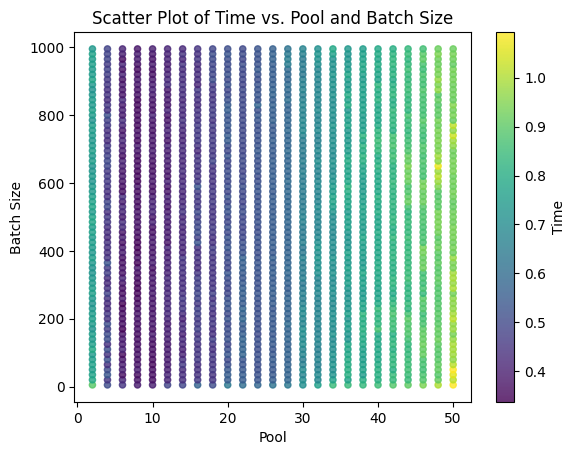

In [41]:
# Scatter plot results
plt.scatter(grid['pool'], grid['batchsize'], c=grid['time'], cmap='viridis', s=20, alpha=0.8)

# Set labels and title
plt.xlabel('Pool')
plt.ylabel('Batch Size')
plt.title('Scatter Plot of Time vs. Pool and Batch Size')

cbar = plt.colorbar()
cbar.set_label('Time')

In [45]:
print('shortest time')
grid.loc[grid['time'].idxmin()]

shortest time


pool                6
batchsize         245
time         0.337724
Name: 150, dtype: object

In [12]:
processed_headlines_parallel[0:5]

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep totally nails why congress is falling short on gender racial equality',
 'eat your veggies deliciously different recipes',
 'inclement weather prevents liar from getting to work',
 'mother comes pretty close to using word streaming correctly']

## More preprocessing for Word Cloud

In [46]:
# Function to remove stopwords from a headline and lemmatize words (for Word cloud)
def process_headline(headline):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    words = word_tokenize(headline)
    filtered_words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    
    return ' '.join(filtered_words)

filtered_headlines = [process_headline(headline) for headline in processed_headlines_sequential]
filtered_headlines[0:20]

['thirtysomething scientist unveil doomsday clock hair loss',
 'dem rep totally nail congress falling short gender racial equality',
 'eat veggie deliciously different recipe',
 'inclement weather prevents liar getting work',
 'mother come pretty close using word streaming correctly',
 'white inheritance',
 'way file tax le stress',
 'richard bransons globalwarming donation nearly much cost failed balloon trip',
 'shadow government getting large meet marriott conference room b',
 'lot parent know scenario',
 'lesbian considered father indiana amazing one',
 'amanda peet told daughter sex special hug',
 'know regarding current treatment ebola',
 'chris christie suggests hillary clinton blame boko harams kidnapping hundred schoolgirl',
 'ford develops new suv run purely gasoline',
 'uber ceo travis kalanick stepping trump economic advisory council',
 'area boy enters jumpingandtouchingtopsofdoorways phase',
 'area man traveling gurney',
 'leave person disability behind',
 'linmanuel mira

## Word Cloud
Based on: https://www.kaggle.com/code/eisgandar/sarcastic-headlines-detector-lstm

<function matplotlib.pyplot.show(close=None, block=None)>

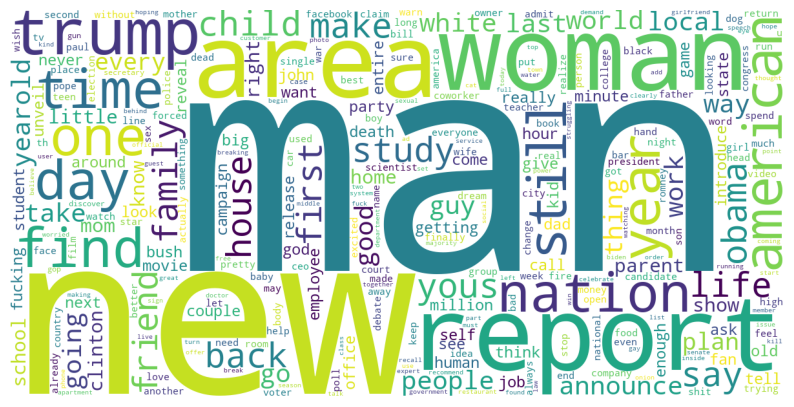

In [47]:
#Sarcastic headlines word cloud
text = " ".join(i for i in [headline for headline, label in zip(filtered_headlines, labels) if label == 1])

wc = WordCloud(background_color = "white",
               width = 1200,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 300,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [10, 10])
plt.imshow(wc)
plt.axis("off")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

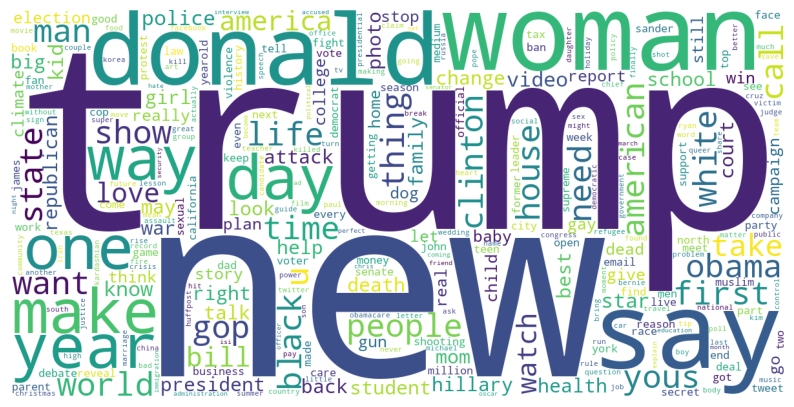

In [48]:
#Non sarcastic headlines word cloud
text = " ".join(i for i in [headline for headline, label in zip(filtered_headlines, labels) if label == 0])

wc = WordCloud(background_color = "white",
               width = 1200,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 300,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [10, 10])
plt.imshow(wc)
plt.axis("off")
plt.show

## Train, Test and Validation Set

In [60]:
processed_headlines = processed_headlines_parallel # or filtered headlines to also remove sw & lemmatize
#processed_headlines = filtered_headlines # or filtered headlines to also remove sw & lemmatize

train_hl, test_hl, train_l, test_l = model_selection.train_test_split(processed_headlines, labels,
                                                                    test_size = 0.10,
                                                                    shuffle = True,
                                                                    random_state = 1)

train_hl, val_hl, train_l, val_l = model_selection.train_test_split(train_hl, train_l,
                                                                    test_size = 0.10,
                                                                    shuffle = True,
                                                                    random_state = 1)

len(train_hl), len(val_hl), len(test_hl)

(23086, 2566, 2851)

# 2) Logistic regression
Based on: https://colab.research.google.com/drive/1yI2EiIqzZmXNzhQDgJqlKadoG1jjAXDm

In [11]:
#Convert a collection of text documents to a matrix of token counts
cv = CountVectorizer(binary=False, min_df=2, max_df=1.0)

cv_train_features = cv.fit_transform(train_hl)
cv_test_features = cv.transform(test_hl)
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (23086, 13389)  Test features shape: (2851, 13389)


In [12]:
cv_val_features = cv.transform(val_hl)

In [13]:
#Fit the model
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)

    #L2 = regularization, C = inverse of regularization strength, max_iter= Maximum number of iterations taken for the solvers to converge
    #Limited-memory BFGS

# train model
lr.fit(cv_train_features, train_l)

# predict on test data
lr_bow_predictions = lr.predict(cv_test_features)
lr_bow_predictions_val = lr.predict(cv_val_features)

In [14]:
#valuation performance
print(classification_report(val_l, lr_bow_predictions_val))
pd.DataFrame(confusion_matrix(val_l, lr_bow_predictions_val))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1331
           1       0.85      0.82      0.83      1235

    accuracy                           0.84      2566
   macro avg       0.85      0.84      0.84      2566
weighted avg       0.84      0.84      0.84      2566



,0,1
0,1158,173
1,226,1009


In [15]:
#Test set performance
print(classification_report(test_l, lr_bow_predictions))
pd.DataFrame(confusion_matrix(test_l, lr_bow_predictions))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1516
           1       0.82      0.84      0.83      1335

    accuracy                           0.84      2851
   macro avg       0.84      0.84      0.84      2851
weighted avg       0.84      0.84      0.84      2851



,0,1
0,1272,244
1,215,1120


In [16]:
#get probability for class 1
lr_bow_predictions_proba = [sublist[1] for sublist in lr.predict_proba(cv_test_features)]

In [17]:
# Store all test predictions in data frame
predictions = pd.DataFrame()
predictions['headline'] = np.array(test_hl).tolist()
predictions['True label'] = np.array(test_l).tolist()
predictions['log reg'] = lr_bow_predictions.tolist()
predictions['log reg prob'] = lr_bow_predictions_proba
predictions

,headline,True label,log reg,log reg prob
0,somali pirates free asian sailors after years ...,0,0,0.421492
1,coworker has that excuse that is going around,1,1,0.935982
2,praia de iracema is the place you should have ...,0,0,0.006986
3,women reveal the real purpose of workout clothes,0,0,0.120108
4,american politics in moral freefall,0,0,0.345205
...,...,...,...,...
2846,republican congressman the best reason to vote...,0,0,0.101812
2847,walking dead writers regret naming every singl...,1,1,0.808024
2848,that guy from that one show not looking so hot,1,1,0.940251
2849,an open letter to caitlyn jenner,0,0,0.007712


In [18]:
#Export these results
predictions.to_csv('predictions.csv', index=True)

# 3) Deep learning

In [61]:
#function to plot model performance: https://www.kaggle.com/code/ashfakyeafi/sarcasm-detection
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

#function to train the model
def model_training_evaluation(model, 
                             monitor = 'val_loss',
                             epochs = 10,
                             batch_size = 128,
                             patience = 2,
                             verbose = 1):
    # Fit the model
    es = tf.keras.callbacks.EarlyStopping(monitor=monitor, 
                                          patience=patience,
                                          restore_best_weights=True,
                                          verbose=verbose)
    
    history = model.fit(X_train, train_l, 
              validation_data=(X_val, val_l),
              epochs=epochs, 
              batch_size=batch_size, 
              shuffle=True,
              callbacks=[es],
              verbose=1)

    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')

    predictions = (model.predict(X_test)> 0.5).astype("int32")
    print("Accuracy: %.2f%%" % (accuracy_score(test_l, predictions)*100))
    print(classification_report(test_l, predictions))
    display(pd.DataFrame(confusion_matrix(test_l, predictions)))

    return predictions

## 3a) FastText Embeddings + CNN

Based on: https://colab.research.google.com/drive/1yI2EiIqzZmXNzhQDgJqlKadoG1jjAXDm

In [62]:
#Run the lines of codes below once:
!curl https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip -o data.zip
!unzip data.zip

In [63]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(train_hl)
t.word_index['<PAD>'] = 0

In [64]:
print(max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      t.word_index['<UNK>'])

('trmp', 26070) ('<PAD>', 0) 1


In [65]:
train_sequences = t.texts_to_sequences(train_hl)
val_sequences = t.texts_to_sequences(val_hl)
test_sequences = t.texts_to_sequences(test_hl)

In [66]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=26071
Number of Documents=23086


(0.0, 30.0)

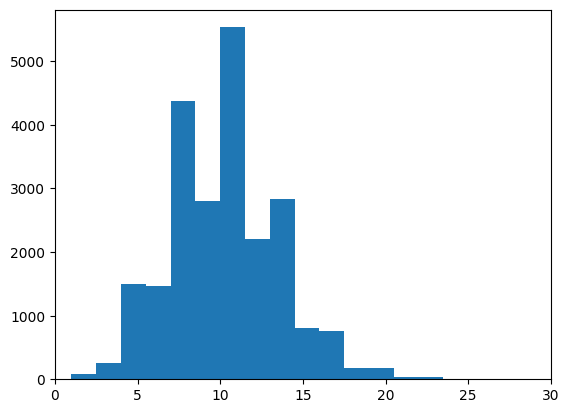

In [67]:
plt.hist([len(doc.split()) for doc in train_hl], bins=100);
plt.xlim([0, 30])

In [68]:
MAX_SEQUENCE_LENGTH = 20

# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_train.shape, X_test.shape

((23086, 20), (2851, 20))

In [69]:
#check out what happened so far
r = 100
print('Original headline: ', train_hl[r])
print('token sequence: ', train_sequences[r])
print('padded sequence: ', X_train[r])

Original headline:  drinking beer could help save this adorable red panda
token sequence:  [1418, 1085, 81, 211, 400, 25, 595, 408, 3135]
padded sequence:  [1418 1085   81  211  400   25  595  408 3135    0    0    0    0    0
    0    0    0    0    0    0]


In [70]:
def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):    
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*row.split(" ")) 
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
                                    if len(row)>100)

    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    
    for word, idx in word_to_index.items():
        if idx >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [71]:
#Parameters
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = './crawl-300d-2M-subword.vec'
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300

In [29]:
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx, 
                                           max_features=VOCAB_SIZE, 
                                           embedding_size=EMBED_SIZE, 
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

(26071, 300)

In [30]:
# cnn model from colab exercise
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings], #use ft_embeddings here
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 300)           7821300   
                                                                 
 conv1d (Conv1D)             (None, 20, 256)           307456    
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 128)           131200    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 64)             3

2024-01-02 12:09:04.398714: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-01-02 12:09:04.398736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 276f5e2443e5
2024-01-02 12:09:04.398741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 276f5e2443e5
2024-01-02 12:09:04.398864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.113.1
2024-01-02 12:09:04.398878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.113.1
2024-01-02 12:09:04.398882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.113.1


Epoch 1/15
181/181 [==============================] - 14s 70ms/step - loss: 0.3940 - accuracy: 0.8079 - val_loss: 0.2771 - val_accuracy: 0.8807
Epoch 2/15
181/181 [==============================] - 12s 69ms/step - loss: 0.1299 - accuracy: 0.9528 - val_loss: 0.3283 - val_accuracy: 0.8819
Epoch 3/15
181/181 [==============================] - 12s 69ms/step - loss: 0.0282 - accuracy: 0.9914 - val_loss: 0.5433 - val_accuracy: 0.8749
Epoch 4/15
181/181 [==============================] - 13s 70ms/step - loss: 0.0139 - accuracy: 0.9946 - val_loss: 0.5943 - val_accuracy: 0.8741
Epoch 5/15
181/181 [==============================] - 13s 70ms/step - loss: 0.0119 - accuracy: 0.9961 - val_loss: 0.6373 - val_accuracy: 0.8655
Epoch 6/15
181/181 [==============================] - 13s 69ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.8581 - val_accuracy: 0.8648
Epoch 7/15
181/181 [==============================] - 13s 70ms/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.9558 - val_accuracy:

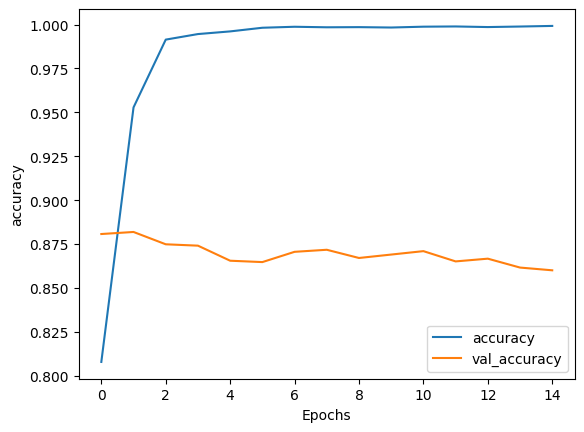

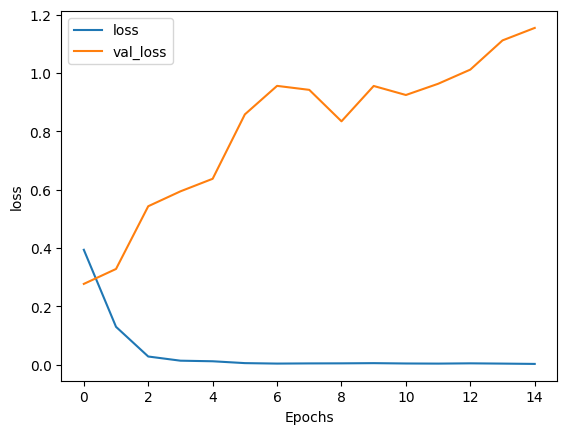

90/90 [==============================] - 0s 2ms/step
Accuracy: 86.60%
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1516
           1       0.87      0.84      0.85      1335

    accuracy                           0.87      2851
   macro avg       0.87      0.86      0.87      2851
weighted avg       0.87      0.87      0.87      2851



,0,1
0,1354,162
1,220,1115


In [31]:
cnn_predictions = model_training_evaluation(model=model, epochs=15, patience = 15)

In [39]:
# Store all test predictions in data frame
predictions['CNN emb'] = np.array([int(p) for p in cnn_predictions]).tolist()
predictions['cnn emb prob'] = model.predict(X_test).flatten().tolist()
predictions

90/90 [==============================] - 0s 2ms/step


,headline,True label,log reg,log reg prob,CNN emb,cnn emb prob
0,somali pirates free asian sailors after years ...,0,0,0.421492,0,1.025366e-03
1,coworker has that excuse that is going around,1,1,0.935982,1,1.000000e+00
2,praia de iracema is the place you should have ...,0,0,0.006986,0,2.394636e-05
3,women reveal the real purpose of workout clothes,0,0,0.120108,0,7.610198e-05
4,american politics in moral freefall,0,0,0.345205,1,7.951905e-01
...,...,...,...,...,...,...
2846,republican congressman the best reason to vote...,0,0,0.101812,0,1.792314e-06
2847,walking dead writers regret naming every singl...,1,1,0.808024,1,9.999998e-01
2848,that guy from that one show not looking so hot,1,1,0.940251,1,9.999985e-01
2849,an open letter to caitlyn jenner,0,0,0.007712,0,5.755566e-16


In [42]:
predictions.to_csv('predictions.csv', index=True, mode='w')

In [33]:
# a much simpler model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings], #use ft_embeddings here
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.Conv1D(filters=2, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 300)           7821300   
                                                                 
 conv1d_3 (Conv1D)           (None, 20, 2)             2402      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 10, 2)             0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 7823723 (29.85 MB)
Trainable params: 7823723 (29.85 MB)
Non-trainable params: 0 (0.00 Byte)
______________

Epoch 1/10
181/181 [==============================] - 9s 45ms/step - loss: 0.6521 - accuracy: 0.6036 - val_loss: 0.5737 - val_accuracy: 0.7389
Epoch 2/10
181/181 [==============================] - 4s 21ms/step - loss: 0.3995 - accuracy: 0.8456 - val_loss: 0.4250 - val_accuracy: 0.8040
Epoch 3/10
181/181 [==============================] - 2s 11ms/step - loss: 0.1973 - accuracy: 0.9328 - val_loss: 0.4491 - val_accuracy: 0.7989
Epoch 4/10
181/181 [==============================] - 2s 9ms/step - loss: 0.0951 - accuracy: 0.9736 - val_loss: 0.4935 - val_accuracy: 0.8005
Epoch 4: early stopping


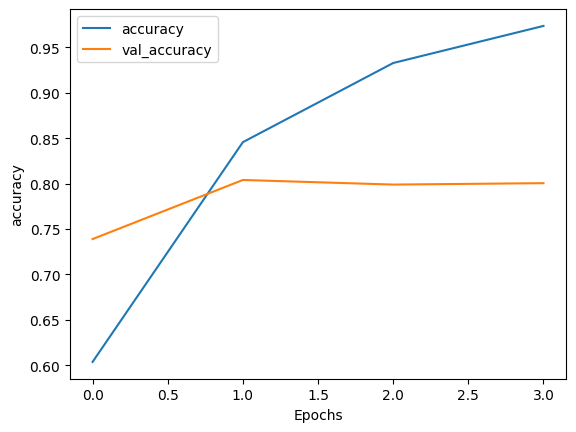

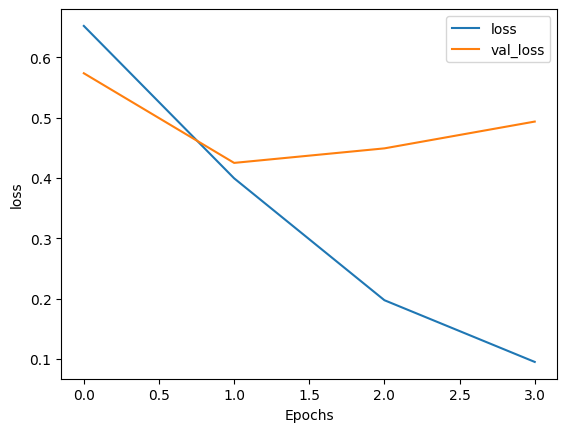

90/90 [==============================] - 0s 2ms/step
Accuracy: 79.90%
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1516
           1       0.76      0.84      0.80      1335

    accuracy                           0.80      2851
   macro avg       0.80      0.80      0.80      2851
weighted avg       0.80      0.80      0.80      2851



,0,1
0,1155,361
1,212,1123


array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]], dtype=int32)

In [34]:
model_training_evaluation(model=model)

## 3b) LSTM
Based on: https://colab.research.google.com/drive/19BCYMuIxoOZ8cdmYtLOWLUZNQ2bs9_fm

In [72]:
#Model from colab exercise
VOCAB_SIZE = len(t.word_index)
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 128 # the number of hidden units in each LSTM cell; total LSTM cells = sequence length (num of tokens)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                    output_dim=EMBEDDING_DIM, 
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.SpatialDropout1D(0.1)) #optional

model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))

model.add(tf.keras.layers.Dense(256, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

2024-01-02 13:11:39.289839: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 29.83MiB (rounded to 31285248)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-01-02 13:11:39.289916: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-01-02 13:11:39.289935: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 21, Chunks in use: 21. 5.2KiB allocated for chunks. 5.2KiB in use in bin. 136B client-requested in use in bin.
2024-01-02 13:11:39.289947: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 1, Chunks in use: 0. 768B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-01-02 13:11:39.289958: I tensorflow/tsl/framework/bf

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[26071,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2] name: 

Epoch 1/10
181/181 [==============================] - 17s 85ms/step - loss: 0.4249 - accuracy: 0.7927 - val_loss: 0.3177 - val_accuracy: 0.8628
Epoch 2/10
181/181 [==============================] - 15s 81ms/step - loss: 0.1921 - accuracy: 0.9284 - val_loss: 0.3527 - val_accuracy: 0.8539
Epoch 3/10
181/181 [==============================] - 15s 84ms/step - loss: 0.1034 - accuracy: 0.9638 - val_loss: 0.3895 - val_accuracy: 0.8500
Epoch 3: early stopping


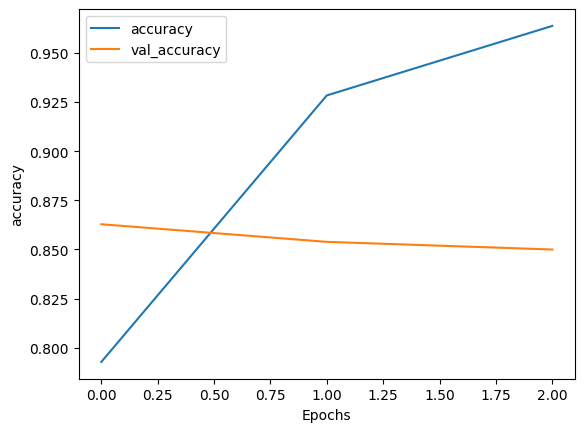

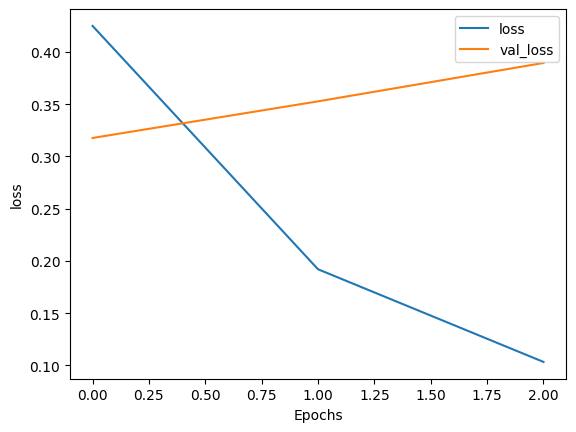

90/90 [==============================] - 1s 5ms/step
Accuracy: 86.18%
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1516
           1       0.84      0.88      0.86      1335

    accuracy                           0.86      2851
   macro avg       0.86      0.86      0.86      2851
weighted avg       0.86      0.86      0.86      2851



,0,1
0,1288,228
1,166,1169


In [44]:
lstm_predictions = model_training_evaluation(model=model)

In [45]:
# Store all test predictions in data frame
predictions['lstm orig'] = np.array([int(p) for p in lstm_predictions]).tolist()
predictions['lstm orig prob'] = model.predict(X_test).flatten().tolist()
predictions

90/90 [==============================] - 0s 4ms/step


,headline,True label,log reg,log reg prob,CNN emb,cnn emb prob,lstm orig,lstm orig prob
0,somali pirates free asian sailors after years ...,0,0,0.421492,0,1.025366e-03,1,0.601512
1,coworker has that excuse that is going around,1,1,0.935982,1,1.000000e+00,1,0.967155
2,praia de iracema is the place you should have ...,0,0,0.006986,0,2.394636e-05,0,0.023322
3,women reveal the real purpose of workout clothes,0,0,0.120108,0,7.610198e-05,0,0.096858
4,american politics in moral freefall,0,0,0.345205,1,7.951905e-01,0,0.258928
...,...,...,...,...,...,...,...,...
2846,republican congressman the best reason to vote...,0,0,0.101812,0,1.792314e-06,0,0.040199
2847,walking dead writers regret naming every singl...,1,1,0.808024,1,9.999998e-01,1,0.897640
2848,that guy from that one show not looking so hot,1,1,0.940251,1,9.999985e-01,1,0.916060
2849,an open letter to caitlyn jenner,0,0,0.007712,0,5.755566e-16,0,0.006972


In [46]:
predictions.to_csv('predictions.csv', index=True, mode='w')

## 3c) LSTM with optuna parameters

Based on: https://www.analyticsvidhya.com/blog/2022/01/multi-label-text-classification-using-transfer-learning-powered-by-optuna/

In [175]:
#https://www.analyticsvidhya.com/blog/2022/01/multi-label-text-classification-using-transfer-learning-powered-by-optuna/
def objective(trial):
    #keras.backend.clear_session()
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "SGD"]) #, "RMSprop", "Adadelta"
    epochs = trial.suggest_int("epochs", 2, 32,step=5, log=False)
    batchsize = trial.suggest_int('size', 8, 64, step=8)
    embeddingdim = trial.suggest_int('embedding', 5, 105, step= 10)
    lstmdim = trial.suggest_int('lstm', 5, 105, step= 10)
    droprate = trial.suggest_float('dropout', 0.0, 0.6, step=0.1)
 
    #optimum number of hidden layers
    n_layers = trial.suggest_int('n_layers', 1, 5, step=1)
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                    output_dim=embeddingdim, 
                                    input_length=MAX_SEQUENCE_LENGTH))

    model.add(tf.keras.layers.SpatialDropout1D(droprate)) #optional

    model.add(tf.keras.layers.LSTM(lstmdim, return_sequences=False))
    
    for i in range(n_layers):
        #optimum number of hidden nodes
        num_hidden = trial.suggest_int(f'n_units_l{i}', 5, 200, log=True)
        #optimum activation function
        model.add(tf.keras.layers.Dense(num_hidden,
                               activation=trial.suggest_categorical(f'activation{i}', ['relu', 'swish'])))
        #optimum dropout value
        model.add(tf.keras.layers.Dropout(rate = trial.suggest_float(f'dropout{i}', 0.0, 0.7, step=0.1))) 

    model.add(tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)) #output Layer
    
    val_ds = (X_val, val_l)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=1,min_lr=1e-05,verbose=0)
    early_stoping = EarlyStopping(monitor="val_loss",min_delta=0,patience=5,verbose=0,mode="auto", baseline=None,restore_best_weights=True)
    model.compile(loss='binary_crossentropy',metrics=["accuracy"], optimizer=optimizer_name)
    #optimum batch size
    histroy = model.fit(X_train, train_l, validation_data=val_ds,epochs=epochs,callbacks=[reduce_lr,early_stoping],verbose=0,
                       batch_size=batchsize)
    return min(histroy.history['val_loss'])

In [176]:
if __name__ == "__main__":
  study = optuna.create_study(direction="minimize")
  study.optimize(objective, n_trials=100)
  print("Number of finished trials: {}".format(len(study.trials)))
  print("Best trial:")
  trial = study.best_trial
  print("  Value: {}".format(trial.value))

[I 2023-12-27 20:23:41,540] A new study created in memory with name: no-name-48ef4a5a-1ebf-4022-bb50-b1931ab32862
[I 2023-12-27 20:24:21,169] Trial 0 finished with value: 0.31084349751472473 and parameters: {'optimizer': 'adam', 'epochs': 17, 'size': 24, 'embedding': 95, 'lstm': 105, 'dropout': 0.6, 'n_layers': 1, 'n_units_l0': 18, 'activation0': 'relu', 'dropout0': 0.7}. Best is trial 0 with value: 0.31084349751472473.
[I 2023-12-27 20:25:48,254] Trial 1 finished with value: 0.3217969536781311 and parameters: {'optimizer': 'adam', 'epochs': 27, 'size': 8, 'embedding': 95, 'lstm': 95, 'dropout': 0.6, 'n_layers': 2, 'n_units_l0': 186, 'activation0': 'relu', 'dropout0': 0.30000000000000004, 'n_units_l1': 24, 'activation1': 'swish', 'dropout1': 0.1}. Best is trial 0 with value: 0.31084349751472473.
[I 2023-12-27 20:26:34,753] Trial 2 finished with value: 0.692348301410675 and parameters: {'optimizer': 'SGD', 'epochs': 17, 'size': 48, 'embedding': 85, 'lstm': 105, 'dropout': 0.2, 'n_layers

Number of finished trials: 100
Best trial:
  Value: 0.3010110557079315


In [125]:
#optuna.visualization.plot_optimization_history(study)

In [177]:
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

  Params: 
    optimizer: adam
    epochs: 27
    size: 16
    embedding: 105
    lstm: 85
    dropout: 0.6
    n_layers: 5
    n_units_l0: 81
    activation0: relu
    dropout0: 0.4
    n_units_l1: 108
    activation1: relu
    dropout1: 0.1
    n_units_l2: 53
    activation2: relu
    dropout2: 0.4
    n_units_l3: 109
    activation3: swish
    dropout3: 0.4
    n_units_l4: 41
    activation4: swish
    dropout4: 0.4


In [47]:
#Implement best model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                    output_dim=105, 
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.SpatialDropout1D(0.6)) #optional

model.add(tf.keras.layers.LSTM(85, return_sequences=False))

model.add(tf.keras.layers.Dense(81, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.4)) 
model.add(tf.keras.layers.Dense(108, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.1)) 
model.add(tf.keras.layers.Dense(53, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.4)) 

model.add(tf.keras.layers.Dense(109, activation='swish'))
model.add(tf.keras.layers.Dropout(rate = 0.4)) 
model.add(tf.keras.layers.Dense(41, activation='swish'))
model.add(tf.keras.layers.Dropout(rate = 0.4)) 

model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 105)           2737455   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 20, 105)           0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 85)                64940     
                                                                 
 dense_5 (Dense)             (None, 81)                6966      
                                                                 
 dropout_2 (Dropout)         (None, 81)                0         
                                                                 
 dense_6 (Dense)             (None, 108)               8856      
                                                      

In [48]:
val_ds = (X_val, val_l)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=1,min_lr=1e-05,verbose=0)
early_stoping = EarlyStopping(monitor="val_loss",min_delta=0,patience=5,verbose=0,mode="auto", baseline=None,restore_best_weights=True)

histroy = model.fit(X_train, train_l, validation_data=val_ds,epochs=27,callbacks=[reduce_lr,early_stoping],verbose=1,
                    batch_size=16)

Epoch 1/27
1443/1443 [==============================] - 36s 23ms/step - loss: 0.4540 - accuracy: 0.7826 - val_loss: 0.3207 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 2/27
1443/1443 [==============================] - 32s 22ms/step - loss: 0.2645 - accuracy: 0.9033 - val_loss: 0.3170 - val_accuracy: 0.8691 - lr: 0.0010
Epoch 3/27
1443/1443 [==============================] - 29s 20ms/step - loss: 0.1827 - accuracy: 0.9347 - val_loss: 0.3657 - val_accuracy: 0.8570 - lr: 0.0010
Epoch 4/27
1443/1443 [==============================] - 29s 20ms/step - loss: 0.0980 - accuracy: 0.9676 - val_loss: 0.4128 - val_accuracy: 0.8636 - lr: 1.0000e-04
Epoch 5/27
1443/1443 [==============================] - 30s 21ms/step - loss: 0.0861 - accuracy: 0.9720 - val_loss: 0.4099 - val_accuracy: 0.8617 - lr: 1.0000e-05
Epoch 6/27
1443/1443 [==============================] - 29s 20ms/step - loss: 0.0843 - accuracy: 0.9727 - val_loss: 0.4143 - val_accuracy: 0.8628 - lr: 1.0000e-05
Epoch 7/27
1443/1443 [============

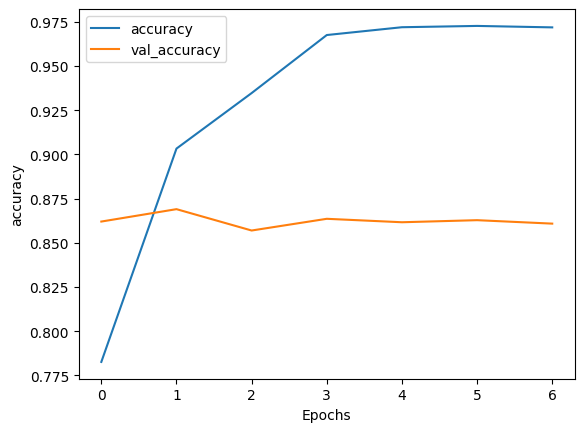

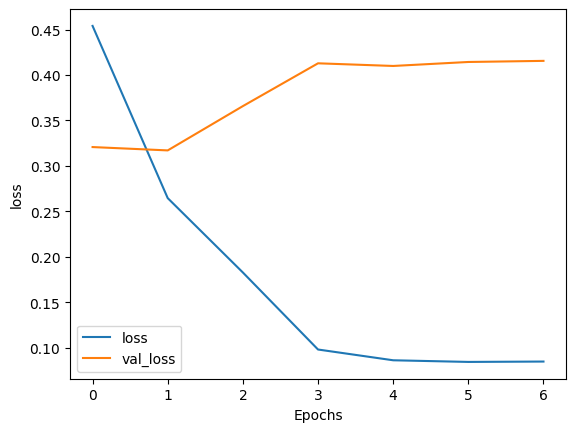

In [49]:
history = histroy #whoops, typo

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [50]:
    lstm2_predictions = (model.predict(X_test)> 0.5).astype("int32")
    print("Accuracy: %.2f%%" % (accuracy_score(test_l, lstm2_predictions)*100))
    print(classification_report(test_l, cnn_predictions))
    display(pd.DataFrame(confusion_matrix(test_l, lstm2_predictions)))

90/90 [==============================] - 1s 3ms/step
Accuracy: 85.86%
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1516
           1       0.87      0.84      0.85      1335

    accuracy                           0.87      2851
   macro avg       0.87      0.86      0.87      2851
weighted avg       0.87      0.87      0.87      2851



,0,1
0,1263,253
1,150,1185


In [51]:
# Store all test predictions in data frame
predictions['lstm optuna'] = np.array([int(p) for p in lstm2_predictions]).tolist()
predictions['lstm optuna prob'] = model.predict(X_test).flatten().tolist()
predictions

90/90 [==============================] - 0s 3ms/step


,headline,True label,log reg,log reg prob,CNN emb,cnn emb prob,lstm orig,lstm orig prob,lstm optuna,lstm optuna prob
0,somali pirates free asian sailors after years ...,0,0,0.421492,0,1.025366e-03,1,0.601512,0,0.347944
1,coworker has that excuse that is going around,1,1,0.935982,1,1.000000e+00,1,0.967155,1,0.942025
2,praia de iracema is the place you should have ...,0,0,0.006986,0,2.394636e-05,0,0.023322,0,0.104018
3,women reveal the real purpose of workout clothes,0,0,0.120108,0,7.610198e-05,0,0.096858,0,0.060956
4,american politics in moral freefall,0,0,0.345205,1,7.951905e-01,0,0.258928,0,0.219102
...,...,...,...,...,...,...,...,...,...,...
2846,republican congressman the best reason to vote...,0,0,0.101812,0,1.792314e-06,0,0.040199,0,0.110235
2847,walking dead writers regret naming every singl...,1,1,0.808024,1,9.999998e-01,1,0.897640,1,0.802880
2848,that guy from that one show not looking so hot,1,1,0.940251,1,9.999985e-01,1,0.916060,1,0.872714
2849,an open letter to caitlyn jenner,0,0,0.007712,0,5.755566e-16,0,0.006972,0,0.042608


In [52]:
predictions.to_csv('predictions.csv', index=True, mode='w')

In [54]:
tf.keras.backend.clear_session()

## 3d) BERT
Based on: https://colab.research.google.com/drive/1yI2EiIqzZmXNzhQDgJqlKadoG1jjAXDm

In [23]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [24]:
def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks, all_segments= [], [], []
    for doc in docs:
        
        tokens = tokenizer.tokenize(doc)
        
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids) # [1,1,1.....] # 500 ones
        
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
            
        segments = [0] * max_seq_length # [0,0,0...] # 500 zeros
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)
        
    encoded = np.array([all_ids, all_masks, all_segments])
    
    return encoded

In [25]:
MAX_SEQ_LENGTH = 20

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_segment_ids")

train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer, 
                                                                                               train_hl, 
                                                                                               max_seq_length=MAX_SEQ_LENGTH)

val_features_ids, val_features_masks, val_features_segments = create_bert_input_features(tokenizer, 
                                                                                         val_hl, 
                                                                                         max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape, train_features_segments.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape, val_features_segments.shape)

Train Features: (23086, 20) (23086, 20) (23086, 20)
Val Features: (2566, 20) (2566, 20) (2566, 20)


In [30]:
#build the model (for output of this model see the "Bert" Notebook, because for some reason it stoped working here)

inputs = [inp_id, inp_mask, inp_segment]

hidden_state = transformers.TFBertModel.from_pretrained('bert-base-uncased')(inputs)
pooled_output = hidden_state[1]

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                           epsilon=1e-08), 
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

2024-01-02 12:51:06.285731: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 89.42MiB (rounded to 93763584)requested by op StatelessTruncatedNormalV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-01-02 12:51:06.285785: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-01-02 12:51:06.285793: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 14, Chunks in use: 14. 3.5KiB allocated for chunks. 3.5KiB in use in bin. 76B client-requested in use in bin.
2024-01-02 12:51:06.285799: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-01-02 12:51:06.285805: I tensorflow/tsl/framework/bfc

ResourceExhaustedError: Exception encountered when calling layer 'bert' (type TFBertMainLayer).

{{function_node __wrapped__StatelessTruncatedNormalV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[30522,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessTruncatedNormalV2] name: 

Call arguments received by layer 'bert' (type TFBertMainLayer):
  • input_ids=tf.Tensor(shape=(1, 2), dtype=int32)
  • attention_mask=tf.Tensor(shape=(1, 2), dtype=int32)
  • token_type_ids=tf.Tensor(shape=(1, 2), dtype=int32)
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=True
  • output_attentions=False
  • output_hidden_states=False
  • return_dict=True
  • training=False

In [29]:
#(see Bert script, because for some reason it stoped working here)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)
history = model.fit([train_features_ids, 
           train_features_masks, 
           train_features_segments], train_l, 
          validation_data=([val_features_ids, 
                            val_features_masks, 
                            val_features_segments], val_l),
          epochs=15, 
          batch_size=32, 
          callbacks=[es],
          shuffle=True,
          verbose=1)

NameError: name 'model' is not defined

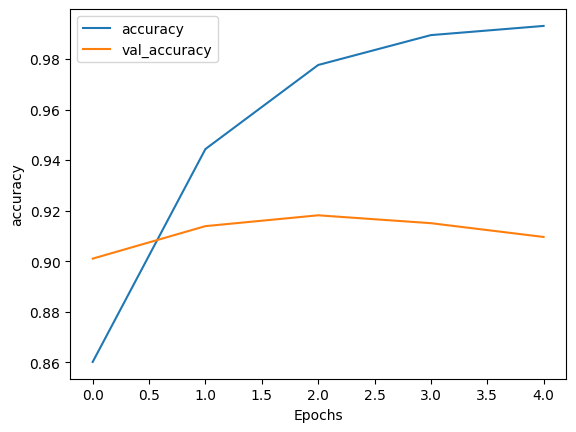

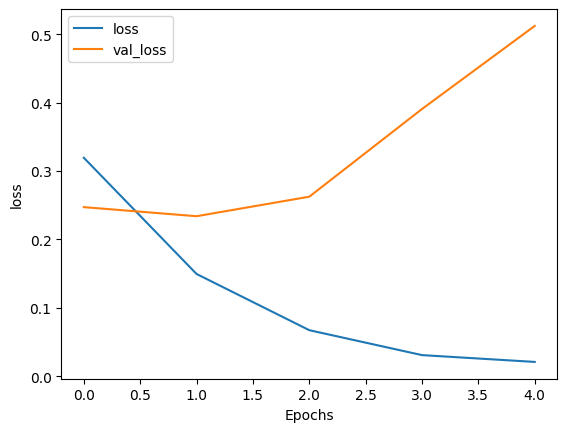

In [82]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [83]:
test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer, 
                                                                                            test_hl, 
                                                                                            max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape, test_features_segments.shape)

Test Features: (2851, 20) (2851, 20) (2851, 20)


In [84]:

bert_predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict([test_features_ids, 
                                            test_features_masks, 
                                            test_features_segments], verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(test_l, bert_predictions)*100))
print(classification_report(test_l, bert_predictions))
pd.DataFrame(confusion_matrix(test_l, bert_predictions))

Accuracy: 92.14%
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1516
           1       0.91      0.92      0.92      1335

    accuracy                           0.92      2851
   macro avg       0.92      0.92      0.92      2851
weighted avg       0.92      0.92      0.92      2851



,0,1
0,1398,118
1,106,1229


In [85]:
predictions['bert'] = np.array([int(p) for p in bert_predictions]).tolist()
pred = model.predict([test_features_ids, test_features_masks, test_features_segments], verbose=0).ravel()


## 3c) Simpler BERT

In [142]:
MAX_SEQ_LENGTH = 10

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_segment_ids")

train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer, 
                                                                                               train_hl, 
                                                                                               max_seq_length=MAX_SEQ_LENGTH)

val_features_ids, val_features_masks, val_features_segments = create_bert_input_features(tokenizer, 
                                                                                         val_hl, 
                                                                                         max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape, train_features_segments.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape, val_features_segments.shape)

Train Features: (23086, 10) (23086, 10) (23086, 10)
Val Features: (2566, 10) (2566, 10) (2566, 10)


In [149]:
#build the model

inputs2 = [inp_id, inp_mask, inp_segment]

hidden_state2 = transformers.TFBertModel.from_pretrained('bert-base-uncased')(inputs2)
pooled_output2 = hidden_state[1]

dense12 = tf.keras.layers.Dense(50, activation='relu')(pooled_output2)
drop12 = tf.keras.layers.Dropout(0.5)(dense12)

output2 = tf.keras.layers.Dense(1, activation='sigmoid')(drop12)

model2 = tf.keras.Model(inputs=inputs2, outputs=output2)

model2.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                           epsilon=1e-08), 
              loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 bert_input_ids (InputLayer  [(None, 10)]                 0         []                            
 )                                                                                                
                                                                                                  
 bert_input_masks (InputLay  [(None, 10)]                 0         []                            
 er)                                                                                              
                                                                                                  
 bert_segment_ids (InputLay  [(None, 10)]                 0         []                            
 er)                                                                                        

In [150]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)
history = model.fit([train_features_ids, 
           train_features_masks, 
           train_features_segments], train_l, 
          validation_data=([val_features_ids, 
                            val_features_masks, 
                            val_features_segments], val_l),
          epochs=15, 
          batch_size=32, 
          callbacks=[es],
          shuffle=True,
          verbose=1)

Epoch 1/15
722/722 [==============================] - 63s 75ms/step - loss: 0.1798 - accuracy: 0.9326 - val_loss: 0.3220 - val_accuracy: 0.8733
Epoch 2/15
722/722 [==============================] - 49s 69ms/step - loss: 0.0799 - accuracy: 0.9718 - val_loss: 0.3387 - val_accuracy: 0.8901
Epoch 3/15
722/722 [==============================] - 49s 68ms/step - loss: 0.0419 - accuracy: 0.9865 - val_loss: 0.4173 - val_accuracy: 0.8819
Epoch 4/15
722/722 [==============================] - 50s 69ms/step - loss: 0.0299 - accuracy: 0.9902 - val_loss: 0.5237 - val_accuracy: 0.8889
Epoch 4: early stopping


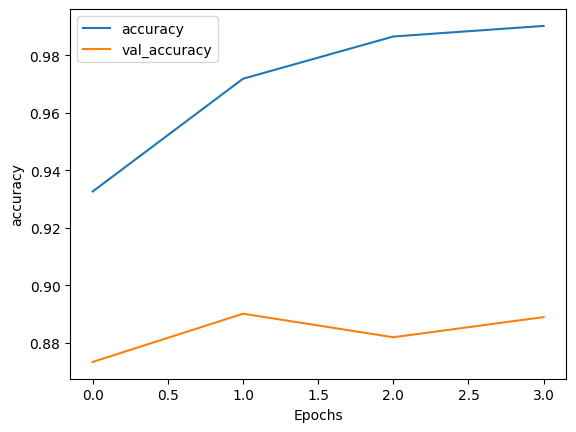

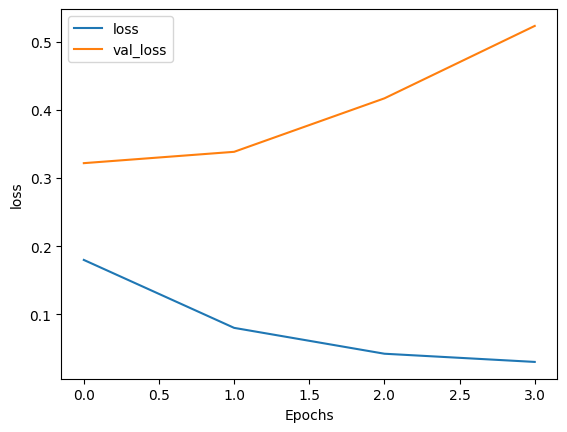

In [151]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [152]:
test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer, 
                                                                                            test_hl, 
                                                                                            max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape, test_features_segments.shape)

Test Features: (2851, 10) (2851, 10) (2851, 10)


In [153]:

bert_predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict([test_features_ids, 
                                            test_features_masks, 
                                            test_features_segments], verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(test_l, bert_predictions)*100))
print(classification_report(test_l, bert_predictions))
pd.DataFrame(confusion_matrix(test_l, bert_predictions))

Accuracy: 88.39%
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1516
           1       0.92      0.82      0.87      1335

    accuracy                           0.88      2851
   macro avg       0.89      0.88      0.88      2851
weighted avg       0.89      0.88      0.88      2851



,0,1
0,1424,92
1,239,1096


# 4) Analyse missclassifications

In [98]:
bert_df = pd.DataFrame(columns=['headline', 'true label', 'bert prediction', 'bert probability'])
bert_df['headline'] = np.array(test_hl).tolist()
bert_df['true label'] = np.array(test_l).tolist()
bert_df['bert prediction'] = np.array([int(p) for p in bert_predictions]).tolist()
bert_df['bert probability'] = np.array(pred).tolist()
bert_df

,headline,true label,bert prediction,bert probability
0,somali pirates free asian sailors after years ...,0,0,0.043865
1,coworker has that excuse that is going around,1,1,0.995492
2,praia de iracema is the place you should have ...,0,0,0.000761
3,women reveal the real purpose of workout clothes,0,0,0.002596
4,american politics in moral freefall,0,0,0.004199
...,...,...,...,...
2846,republican congressman the best reason to vote...,0,0,0.112636
2847,walking dead writers regret naming every singl...,1,1,0.994495
2848,that guy from that one show not looking so hot,1,1,0.979455
2849,an open letter to caitlyn jenner,0,0,0.000427


In [154]:
misclassified_indices = np.where(bert_df['bert prediction'] != bert_df['true label'])[0]
len(misclassified_indices)

224

In [115]:
bert_df_mc = bert_df.iloc[misclassified_indices].sort_values(by='bert probability', ascending=True)
bert_df_mc

,headline,true label,bert prediction,bert probability
2752,get clarity on what the future holds so you ca...,1,0,0.000484
212,no complaints if a remake of emma with jon ham...,1,0,0.000633
2671,this great song bar sources report,1,0,0.001889
2337,plane crash victims were statistically more li...,1,0,0.001969
1886,beloved showbiz legend and national treasure m...,1,0,0.003374
...,...,...,...,...
319,conservative media finally starting to realize...,0,1,0.993343
637,jury awards exemployee of roscoes chicken n wa...,0,1,0.994474
2256,alzheimers journal come back early today,0,1,0.995445
151,indian country all too familiar with rachel do...,0,1,0.995842


In [134]:
#save to csv
bert_df_mc.to_csv('bert_df.csv', index=True)

In [131]:
pd.set_option('display.max_colwidth',3000)
pd.set_option('display.max_rows', 500)
bert_df_mc[0:106]

,headline,true label,bert prediction,bert probability
2752,get clarity on what the future holds so you can go back to worrying about costume ideas,1,0,0.000484
212,no complaints if a remake of emma with jon hamm and emily blunt got thrown our way nations girlfriends report,1,0,0.000633
2671,this great song bar sources report,1,0,0.001889
2337,plane crash victims were statistically more likely to have died in a car crash,1,0,0.001969
1886,beloved showbiz legend and national treasure michael douglas actually none of these things,1,0,0.003374
1212,mom just called to say hi and that she is very sad,1,0,0.005102
2497,there is been an explosion,1,0,0.006620
2304,leatherclad nomads seize power in australia,1,0,0.009117
1366,detroit tourism boards hidden detroit campaign results in deaths,1,0,0.009711
1470,you can hold snake owner reports,1,0,0.010600


In [132]:
bert_df_mc[106:]

,headline,true label,bert prediction,bert probability
851,rubio launches new lines of attack against christie,0,1,0.505657
1398,family finds frozen kitten and nurses him back to life,0,1,0.511367
1492,airbnb apologizes for posting snarky ads aimed at schools libraries,0,1,0.521537
688,shirtless goofball in flag underwear invades field at world series,0,1,0.539788
1792,korean fifty shades parody has crazy twist you will not see coming,0,1,0.545736
771,senate panel unanimously approves chris wrays nomination as fbi director,0,1,0.552943
294,usa today editorial board calls trump unfit to clean obamas toilets in scathing editorial,0,1,0.553779
1635,kerry washington we should not have to give up our seats at the table for others bad behavior,0,1,0.554638
313,indira gandhi years later not a fond memory,0,1,0.564929
1978,nyt column asserts us colleges stink,0,1,0.572176


In [139]:
#Sample for Chat GPT
sample = bert_df_mc.sample(30)
sample  

,headline,true label,bert prediction,bert probability
930,hemmedin seattle mayor calls for emergency deforestation,1,0,0.020433
2554,japanese restrooms offer special toilet paper for wiping phones,0,1,0.990285
851,rubio launches new lines of attack against christie,0,1,0.505657
1470,you can hold snake owner reports,1,0,0.010600
912,noose found in africanamerican history museum exhibit in dc,0,1,0.845978
2631,gop senator sorry for joking about mammograms but still will not cover them,0,1,0.743559
1935,paranormal expert bores son with ghost story,1,0,0.469362
2811,killed in violent kerfuffle,1,0,0.230745
1847,aliens in avocado super bowl ad think we are a bunch of dips,0,1,0.718157
1381,temple university receives anonymous donation to build center for discrediting rape allegations,1,0,0.296117


In [141]:
for r in sample['headline']:
 print(r)

hemmedin seattle mayor calls for emergency deforestation
japanese restrooms offer special toilet paper for wiping phones
rubio launches new lines of attack against christie
you can hold snake owner reports
noose found in africanamerican history museum exhibit in dc
gop senator sorry for joking about mammograms but still will not cover them
paranormal expert bores son with ghost story
killed in violent kerfuffle
aliens in avocado super bowl ad think we are a bunch of dips
temple university receives anonymous donation to build center for discrediting rape allegations
keith olbermann asks if we should give presidentelect pygrabber a chance
stunning health benefits of cotton candy proposed
something thinking about maybe doing something funny with his facial hair
expansive obama state of the union speech to touch on patent law entomology the films of robert altman
surge soda again sells out on amazon
tom gilbert actor who portrays tvs regis philbin to leave regis kelly show
indian country a

# 5) Model comparison

In [3]:
bert = pd.read_csv('bert_predictions.csv')
bert 

,Unnamed: 0,headline,True label,bert,bert prob
0,0,somali pirates free asian sailors after years ...,0,0,0.478111
1,1,coworker has that excuse that is going around,1,1,0.989332
2,2,praia de iracema is the place you should have ...,0,0,0.006333
3,3,women reveal the real purpose of workout clothes,0,0,0.359706
4,4,american politics in moral freefall,0,0,0.020327
...,...,...,...,...,...
2846,2846,republican congressman the best reason to vote...,0,0,0.356458
2847,2847,walking dead writers regret naming every singl...,1,1,0.985304
2848,2848,that guy from that one show not looking so hot,1,1,0.983494
2849,2849,an open letter to caitlyn jenner,0,0,0.002853


In [4]:
all_models = pd.read_csv('predictions.csv')
all_models['bert'] = bert['bert']
all_models['bert prob'] = bert['bert prob']
all_models

,Unnamed: 0,headline,True label,log reg,log reg prob,CNN emb,cnn emb prob,lstm orig,lstm orig prob,lstm optuna,lstm optuna prob,bert,bert prob
0,0,somali pirates free asian sailors after years ...,0,0,0.421492,0,1.025366e-03,1,0.601512,0,0.347944,0,0.478111
1,1,coworker has that excuse that is going around,1,1,0.935982,1,1.000000e+00,1,0.967155,1,0.942025,1,0.989332
2,2,praia de iracema is the place you should have ...,0,0,0.006986,0,2.394636e-05,0,0.023322,0,0.104018,0,0.006333
3,3,women reveal the real purpose of workout clothes,0,0,0.120108,0,7.610198e-05,0,0.096858,0,0.060956,0,0.359706
4,4,american politics in moral freefall,0,0,0.345205,1,7.951905e-01,0,0.258928,0,0.219102,0,0.020327
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2846,2846,republican congressman the best reason to vote...,0,0,0.101812,0,1.792314e-06,0,0.040199,0,0.110235,0,0.356458
2847,2847,walking dead writers regret naming every singl...,1,1,0.808024,1,9.999998e-01,1,0.897640,1,0.802880,1,0.985304
2848,2848,that guy from that one show not looking so hot,1,1,0.940251,1,9.999985e-01,1,0.916060,1,0.872714,1,0.983494
2849,2849,an open letter to caitlyn jenner,0,0,0.007712,0,5.755566e-16,0,0.006972,0,0.042608,0,0.002853


In [109]:
#find the most sarcastic hadline
def most_sarcastic(column):
    pred = all_models[column]
    max_index = np.argmax(pred)
    print(max(pred))
    print(max(list(headlines), key=lambda x: fuzz.ratio(x, test_hl[max_index])))
    print(test_l.iloc[max_index])

    return(max(pred))

most_sarcastic('log reg prob')

0.999930630582742
area man disappointed in self for already being full
1


0.999930630582742

In [105]:
most_sarcastic('cnn emb prob')

1.0
coworker has that excuse that's going around
1


1.0

In [106]:
most_sarcastic('lstm orig prob')

0.99369215965271
pile of dirty clothes on bedroom floor starting to mix with pile of clean clothes on bedroom floor
1


0.99369215965271

In [107]:
most_sarcastic('lstm optuna prob')

0.9730457067489624
man on bus can tell by surroundings he either hasn't reached stop yet or passed stop long time ago
1


0.9730457067489624

In [108]:
most_sarcastic('bert prob')

0.9965112805366516
area man can't wait to get home to look out new window
1


0.9965112805366516

In [112]:
#Get the top ten sarcastic headlines of all models
cols = ['log reg prob','cnn emb prob', 'lstm orig prob', 'lstm optuna prob', 'bert prob']
for c in cols:
    all_models[c +' top'] = all_models[c].apply(lambda x: 1 if x in all_models[c].nlargest(10).values else 0)

In [123]:
all_models['bert prob top'].sum()

10

In [131]:
cols2 = ['log reg prob top','cnn emb prob top', 'lstm optuna prob top', 'bert prob top']

#Get all headlines that are in the top ten for at least 3 models
top_sarcastic_hl = all_models[all_models[cols2].eq(1).sum(axis=1) >= 3]
top_sarcastic_hl

,Unnamed: 0,headline,True label,log reg,log reg prob,CNN emb,cnn emb prob,lstm orig,lstm orig prob,lstm optuna,lstm optuna prob,bert,bert prob,log reg most,log reg prob top,cnn emb prob top,lstm orig prob top,lstm optuna prob top,bert prob top
740,740,nations parents announce they have zero fuckin...,1,1,0.999882,1,1.0,1,0.992064,1,0.969389,1,0.995648,1,1,1,1,1,0
1075,1075,man on bus can tell by surroundings he either ...,1,1,0.999735,1,1.0,1,0.992854,1,0.973046,1,0.995520,1,1,1,1,1,0
1112,1112,man putting off starting family to focus on tr...,1,1,0.999607,1,1.0,1,0.991095,1,0.968704,1,0.995528,1,1,1,0,1,0
1773,1773,area man cannot wait to get home to look out n...,1,1,0.999575,1,1.0,1,0.990693,1,0.965714,1,0.996511,1,1,1,0,0,1
2830,2830,area man will be judge of whether woman actual...,1,1,0.999584,1,1.0,1,0.986756,1,0.960970,1,0.996382,1,1,1,0,0,1
2836,2836,pile of dirty clothes on bedroom floor startin...,1,1,0.999226,1,1.0,1,0.993692,1,0.971971,1,0.996094,0,0,1,1,1,1


In [130]:
#Get the original headlines (because data cleaning was done before splitting into sets - which should be done differently next time)

for hl in top_sarcastic_hl['headline']:
    print(max(list(headlines), key=lambda x: fuzz.ratio(x, hl)))

nation's parents announce they have zero fucking patience for this bullshit
man on bus can tell by surroundings he either hasn't reached stop yet or passed stop long time ago
man putting off starting family to focus on treading water in career for few years
area man can't wait to get home to look out new window
area man will be judge of whether woman actually true baseball fan
pile of dirty clothes on bedroom floor starting to mix with pile of clean clothes on bedroom floor


In [25]:
#Check Trump predictions
trump = all_models[(all_models['headline'].str.contains('Trump', case=False))] #& (all_models['True label'] == 1)]

# Calculate accuracy
correct_predictions = (trump['True label'] == trump['bert']).sum()
total_rows = len(trump)
accuracy = correct_predictions / total_rows
accuracy

0.9273743016759777

In [17]:
trump['bert prob']

66      0.395974
98      0.531598
146     0.987640
213     0.982093
376     0.995636
386     0.990405
389     0.917297
631     0.763106
652     0.886406
662     0.695551
757     0.322525
763     0.992578
836     0.994031
881     0.639770
985     0.977711
1132    0.991995
1134    0.604802
1144    0.990654
1169    0.647533
1301    0.781786
1388    0.948713
1454    0.884165
1631    0.962463
1668    0.836622
1708    0.647656
1730    0.951171
1748    0.501960
1819    0.945484
1848    0.994161
2084    0.506195
2241    0.804424
2273    0.964922
2313    0.984729
2360    0.790501
2369    0.993462
2381    0.592535
2610    0.689127
2764    0.906011
2810    0.142375
Name: bert prob, dtype: float64

In [97]:
#Function to find the top most sarcastic headlin (given a probability cut off) for a given model
def top_most_sarcastic(column, cut_off = 1):
    pred = all_models[column]
    most_starcastic = (pred >= cut_off).astype("int32")
    ba = np.array(most_starcastic==1)
    true_indices = np.where(ba.flatten())[0]
    print(len(true_indices))
    
    for i in true_indices:
        print(pred[i])
        print(max(list(headlines), key=lambda x: fuzz.ratio(x, test_hl[i])))
        print(test_l.iloc[i])

top_most_sarcastic(cut_off=0.999, column='log reg prob')

28
0.9991305603580792
spoon's weight topples pint in jarring reminder of how much ice cream area man ate in one sitting
1
0.9991964028516128
iranian scientist annoyed he has to go back to shitty old job building nuclear weapons
1
0.9996051378033092
shell assures nation most arctic wildlife to go extinct well before next spill
1
0.9997622565379382
man not himself until he has so much coffee he feels like he's going to die
1
0.999881983947402
nation's parents announce they have zero fucking patience for this bullshit
1
0.9993350256699212
bolton argues war with iran only way to avenge americans killed in upcoming war with iran
1
0.9993711977421322
nation's creepy middle school gym teachers also come out in favor of circumcision
1
0.9997349925626344
man on bus can tell by surroundings he either hasn't reached stop yet or passed stop long time ago
1
0.9996072496759062
man putting off starting family to focus on treading water in career for few years
1
0.9996308726658132
area woman not good 